### **Project Overview**



In this notebook we will analyze **if the happiness score is affected by the country's nature**. We define the Country's Nature by the GDP, Population Density, Status,Trust, Perceptions of corruption and Total health Expenditure.

**So our research question is actually divided into 6:** 

  Is the happiness score of a country affected by:
  * The Development Status of the country?
  * The Population Density of the country?
  * The GDP per capita(Gross Domestic Product per person) in the country?
  * The Total Health Expenditure in the country?
  * The Perceptions of corruption in the country?
  * The level of Trust between the country's government and its people?


**We had 5 raw datasets and we applied the following:**

1.   Data Cleaning
2.   Data Transformation
3.   Data Integration
4.   Data Reduction
5.   Data Visualization

**DataSets:**

1.   **World Happiness Report Dataset:**

     The World Happiness Report is a landmark survey of the state of global happiness. The first report was published in 2012, the second in 2013, the third in 2015, and the fourth in the 2016 Update. The World Happiness 2017, which ranks 155 countries by their happiness levels, was released at the United Nations at an event celebrating International Day of Happiness on March 20th. The report continues to gain global recognition as governments, organizations and civil society increasingly use happiness indicators to inform their policy-making decisions. Leading experts across fields – economics, psychology, survey analysis, national statistics, health, public policy and more – describe how measurements of well-being can be used effectively to assess the progress of nations. The reports review the state of happiness in the world today and show how the new science of happiness explains personal and national variations in happiness.

     It has 12 columns and we are interested in the Country, Region, GDP Score, Health expenditure, and Happiness Score columns as well as 5 files and we choose 2019 file since our project is dedicated to explore the changes in this year.



2. **All 250 Country Dataset:** 


> This Data set contains 250 rows, Each row is a Country. There are 11 columns. Such as name, region, subregion, population, area, Gini, real growth, rate, literacy rate, inflation, and unemployment
The First 7 columns are taken from an API and the rest are collected from a website named infoplease by web scraping.
The last 4 column data are mention out of 100 that's why the column name contains a '%'.

>It has 11 columns and we are interested in the Country, Region, and Area columns.



3. **Life Expectancy (WHO) DataSet:**

  The project relies on accuracy of data. The Global Health Observatory (GHO) data repository under World Health Organization (WHO) keeps track of the health status as well as many other related factors for all countries The data-sets are made available to public for the purpose of health data analysis. The data-set related to life expectancy, health factors for 193 countries has been collected from the same WHO data repository website and its corresponding economic data was collected from United Nation website. 

  It has 22 columns and we are interested in the Country, Year, and status columns.



4.  **Population of the World Dataset:**

   we used the table in wkikipedia to be able to have the list of population for each country https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population

   We used the Country and Population columns



5. **Countries names Dataset:**

   This Dataset contains 228 countries and we used this dataset to be able to integrate the 4 datasets together since we are grouping by country.






### **Imports and google drive authentication**

In [ ]:
#---------------------------- Imports---------------------------#
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot


import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import requests
import logging

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
import sklearn.preprocessing as preprocessing

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import seaborn as sns


In [ ]:
!pip install PyDrive

In [ ]:
#----------------- Google Drive authentication--------------#
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### **Datasets**

In [ ]:
#---------------- Download Datasets from drive--------------#

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768  # i think changing this would make it useful for bigger zip files

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [ ]:
#--------------Download the files-------------
file_id = '1WDL6fdU1sNCLjwX3uZvvF7fEsBETUXan'
download_file_from_google_drive(file_id, './sample_data/All_250_Country_Data.zip')

file_id = '1NvGdf9ZjUpe1cjrG9BT-fDsBwXAz1IQM'
download_file_from_google_drive(file_id, './sample_data/Life_Expectancy.zip')

file_id = '1vqf0USxWu9Lw9xBegQeUQJKyx0svxfd0'
download_file_from_google_drive(file_id, './sample_data/World_Happiness.zip')

file_id = '1F9TQBC2HDCLlgT5qZCnhQCYtu8p8SRMp'
download_file_from_google_drive(file_id, './Population2019.csv')

file_id = '1R6zHfH3FnvbVP-grThET-q2NKjuN2FWa'
download_file_from_google_drive(file_id, './countries of the world.csv')

#--------------Extract the 3 datasets----------------
!jar -xf '/content/sample_data/All_250_Country_Data.zip'
!jar -xf '/content/sample_data/Life_Expectancy.zip'
!jar -xf '/content/sample_data/World_Happiness.zip'

#------------ Read the needed datasets----------------
world_happiness_2019 = pd.read_csv('/content/2019.csv')
Country_Data_250 = pd.read_csv('/content/250 Country Data.csv')
Life_Expectancy_Data = pd.read_csv('/content/Life Expectancy Data.csv')

display(world_happiness_2019.head(),Country_Data_250.head(),Life_Expectancy_Data.head())

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


,Unnamed: 0,name,region,subregion,population,area,gini,Real Growth Rating(%),Literacy Rate(%),Inflation(%),Unemployement(%)
0,0,Afghanistan,Asia,Southern Asia,27657145,652230.0,27.8,3.1% (2013 est.).,28.1% (2000 est.),6.8% (2013 est.).,35% (2008 est.).
1,1,Åland Islands,Europe,Northern Europe,28875,1580.0,NaN,NaN,NaN,NaN,NaN
2,2,Albania,Europe,Southern Europe,2886026,28748.0,34.5,.7% (2013 est.).,98.7% (2011 est.),1.7% (2013 est.).,16.9% official rate (2013 est.). Note: These a...
3,3,Algeria,Africa,Northern Africa,40400000,2381741.0,35.3,3.1%.,79%,3.9%.,10.3%.
4,4,American Samoa,Oceania,Polynesia,57100,199.0,NaN,3%.,97% (1980 est.),NaN,NaN


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


### **Data Tidying for the population, the WHO, and the 250 country dataset**

#### **For the population dataset**

1. Read the Countries List Dataset
2. Make the country column consistent by having all countries in lower case letters

In [ ]:
#--------------- Get the list of countries around the world---------------
CountriesList = pd.read_csv('/content/Population2019.csv',encoding= 'unicode_escape')
CountriesList["Country"] = CountriesList["Country"].str.lower()
CountriesList.update(CountriesList)
CountriesList

,Country,Population
0,china,"1,433,783,686"
1,india,"1,366,417,754"
2,united states,"329,064,917"
3,indonesia,"270,625,568"
4,pakistan,"216,565,318"
...,...,...
192,san marino,"33,860"
193,palau,"18,008"
194,tuvalu,"11,646"
195,nauru,"10,756"


#### **For the World Happiness Dataset**



1. Drop uneeded columns
2. Check the conisitency of the Country/Region column
3. Create a Country column
4. Feature Engineer a Trust column

In [ ]:
#-----------------------drop the un-needed columns in happiness data--------------------#
world_happiness_updated = world_happiness_2019.drop(['Overall rank', 'Social support','Healthy life expectancy','Freedom to make life choices','Generosity'], axis=1)
world_happiness_updated["Country or region"] = world_happiness_updated["Country or region"].str.lower()
world_happiness_updated["Trust"]= 1 - world_happiness_updated["Perceptions of corruption"]
#world_happiness_updated = world_happiness_updated.drop(["Perceptions of corruption"], axis=1)

#------------- Create a country Column and Drop the 'Country or region' column------
world_happiness_updated[(world_happiness_updated['Country or region'] == 'africa') | (world_happiness_updated['Country or region'] == 'asia')| (world_happiness_updated['Country or region'] == 'caribbean')| (world_happiness_updated['Country or region'] == 'central america')|(world_happiness_updated['Country or region'] == 'europe')|(world_happiness_updated['Country or region'] == 'north america')| (world_happiness_updated['Country or region'] == 'oceania')| (world_happiness_updated['Country or region'] == 'south america')]
print("World_happiness_data has no regions")
print("the number of unique countries in happiness dataset",world_happiness_updated['Country or region'].nunique())
world_happiness_updated = world_happiness_updated.rename(columns={"Country or region": "Country"})

# print(world_happiness_updated)
world_happiness_updated.head()

World_happiness_data has no regions
the number of unique countries in happiness dataset 156


,Country,Score,GDP per capita,Perceptions of corruption,Trust
0,finland,7.769,1.340,0.393,0.607
1,denmark,7.600,1.383,0.410,0.590
2,norway,7.554,1.488,0.341,0.659
3,iceland,7.494,1.380,0.118,0.882
4,netherlands,7.488,1.396,0.298,0.702


#### **Merge1 updated happiness and updated population datasets obtained from the previous 2 steps**

In [ ]:
#-------------Merge updated happiness and countrylist datasets---------------#
score = []
GDP = []
Trust =[]
cor=[]
countries = CountriesList["Country"]
for i in range(0, len(countries)):
  country = countries[i]
  check = False
  for j in range(0,len(world_happiness_updated)):
     if(country.strip() == world_happiness_updated["Country"][j].strip()):
          GDP.append(world_happiness_updated["GDP per capita"][j])
          score.append(world_happiness_updated["Score"][j])
          Trust.append(world_happiness_updated["Trust"][j])
          cor.append(world_happiness_updated["Perceptions of corruption"][j])
          check = True
             
  if(check== False):
    GDP.append(0)
    score.append(0)
    Trust.append(1)   
    cor.append(0)
  
CountriesList.insert(1,"Happiness_score",score,True)
CountriesList.insert(2,"GDP",GDP,True)
CountriesList.insert(3,"Trust",Trust,True)
CountriesList.insert(4,"Perceptions of corruption",cor,True)
CountriesList.to_csv (r'Happiness_Updated.csv', index = False, header=True,encoding='utf-8-sig')
CountriesList.rename(columns={'Happiness_score': 'Happiness Score'}, inplace= True)
CountriesList.head()

,Country,Happiness Score,GDP,Trust,Perceptions of corruption,Population
0,china,5.191,1.029,0.900,0.100,"1,433,783,686"
1,india,4.015,0.755,0.915,0.085,"1,366,417,754"
2,united states,6.892,1.433,0.872,0.128,"329,064,917"
3,indonesia,5.192,0.931,0.972,0.028,"270,625,568"
4,pakistan,5.653,0.677,0.902,0.098,"216,565,318"


#### **For the 250 Country Dataset**


1. Drop uneeded columns
2. Make the Country column consistent

In [ ]:
#-----------------------drop the un-needed columns in 250 data--------------------#
Country_Data_250_updated =Country_Data_250.drop(['subregion', 'population','gini','Real Growth Rating(%)','Literacy Rate(%)','Inflation(%)','Unemployement(%)','Unnamed: 0'], axis=1)
Country_Data_250_updated["name"] = Country_Data_250_updated["name"].str.lower()
Country_Data_250_updated = Country_Data_250_updated.rename(columns={'name': 'Country'}, index={'name': 'Country'})

print(Country_Data_250_updated.columns)
Country_Data_250_updated["region"] = Country_Data_250_updated["region"].str.lower()

Country_Data_250_updated.to_csv (r'Country_Data_250_updated.csv', index = False, header=True,encoding='utf-8-sig')

#--------------250 Countries dataset----------#
print("the number of unique countries in 250 dataset is :",Country_Data_250_updated['Country'].nunique())
print("the number of unique regions in 250 dataset is :",Country_Data_250_updated['region'].nunique())   # repeated countries (dirty Data)


Index(['Country', 'region', 'area'], dtype='object')
the number of unique countries in 250 dataset is : 250
the number of unique regions in 250 dataset is : 6


#### **Merge2 updated 250Dataset with the dataset obtained from the Merge1 step above**

In [ ]:
#-------------Merge the updated 250Dataset with the countriesList---------------#
area=[]
countries = CountriesList["Country"]
for i in range(0, len(countries)):
  country = countries[i]
  check = False
  for j in range(0,len(Country_Data_250_updated)):
     if(country.strip() == Country_Data_250_updated["Country"][j].strip()):
          area.append(Country_Data_250_updated["area"][j])
          check = True
     #else #didn't match
                   
  if(check== False):
    area.append(0)
  
CountriesList.insert(3,"Area",area,True)
CountriesList.to_csv (r'CountriesList_Updated.csv', index = False, header=True,encoding='utf-8-sig')
CountriesList.head()

,Country,Happiness Score,GDP,Area,Trust,Perceptions of corruption,Population
0,china,5.191,1.029,9640011.0,0.900,0.100,"1,433,783,686"
1,india,4.015,0.755,3287590.0,0.915,0.085,"1,366,417,754"
2,united states,6.892,1.433,0.0,0.872,0.128,"329,064,917"
3,indonesia,5.192,0.931,1904569.0,0.972,0.028,"270,625,568"
4,pakistan,5.653,0.677,881912.0,0.902,0.098,"216,565,318"


### **Data cleaning** 

**We now have a merged Dataset and we need to start the Data Cleaning Process:**
1. Search for missing values in the Happniess Score attribute:
   
   - The Happiness score ranges from 2.84 to 7.59
   - A Happiness score of "0" means that the Data was missing
   - Search for "0" Happniess score and calculate the perecentage of missing   value
   
   



In [ ]:
Number_of_missing = (len(CountriesList.loc[(CountriesList['Happiness Score'] == 0)]))
Total_Number = (len(CountriesList))
Percentage = (Number_of_missing/Total_Number)*100
print(Percentage)

24.873096446700508


2. The Happiness Score can't be dropped since its missing values are more than 2%.

  We will investigate the Happiness score more.

  The Happiness score is a metric measured by asking the sampled people the question: "How would you rate your happiness on a scale of 0 to 10 where 10 is the happiest." The minimum was 2.84 and the maximum was 7.59. This measurement can't be computed from other columns because it is missing for the merged countries which also have missing values for the other columns.

3. Apply Imputation technique due to the above limiations and we will impute by taking the average value of the happiness Score Column 

In [ ]:
#-------------- Compute the Average Score and clean the Dataset ------------
Total_Sum = CountriesList["Happiness Score"].sum()
Average = Total_Sum/(Total_Number-Number_of_missing)

#----Impute Happiness Score Values---#
CountriesList.loc[(CountriesList['Happiness Score'] == 0),"Happiness Score"] = Average
CountriesList.to_csv (r'CountriesList_ImputedHappinessScore.csv', index = False, header=True,encoding='utf-8-sig')
CountriesList.head()

,Country,Happiness Score,GDP,Area,Trust,Perceptions of corruption,Population
0,china,5.191,1.029,9640011.0,0.900,0.100,"1,433,783,686"
1,india,4.015,0.755,3287590.0,0.915,0.085,"1,366,417,754"
2,united states,6.892,1.433,0.0,0.872,0.128,"329,064,917"
3,indonesia,5.192,0.931,1904569.0,0.972,0.028,"270,625,568"
4,pakistan,5.653,0.677,881912.0,0.902,0.098,"216,565,318"


4. Search for missing values in the Area Attribute:
   - A "0" value indicates that the area is missing since it is out of its range.
   

In [ ]:
Number_of_missing_Area = (len(CountriesList.loc[(CountriesList['Area'] == 0)]))
Total_Number_Area = (len(CountriesList))
Percentage = (Number_of_missing_Area/Total_Number_Area)*100
print(Percentage)

12.690355329949238


5. The missing values are more than 2%:
  - Since the Area is known information so we will use Data Integration to impute the area values of the countries of the missing values.

6. Read the Countries World Dataset, clean it, apply consistency, and intergate them in the missing values

  **Note:** the Area in both is km^2 so we can safely integrate the areas.

In [ ]:
#----------------- Read CountriesWorld Dataset----------------
countries_of_the_world = pd.read_csv('/content/countries of the world.csv')

#----------------- Drop Un-needed Columns------------
countries_of_the_world = countries_of_the_world.drop(['Region','Population','Pop. Density (per sq. mi.)','Coastline (coast/area ratio)','Infant mortality (per 1000 births)','GDP ($ per capita)','Literacy (%)','Phones (per 1000)','Arable (%)','Crops (%)','Other (%)','Climate','Birthrate','Deathrate','Agriculture','Industry','Service','Net migration'], axis=1)
countries_of_the_world["Country"] = countries_of_the_world["Country"].str.lower()


In [ ]:
#-----------Insert the Area values---------------
Countries_missing_Area = CountriesList.loc[(CountriesList['Area'] == 0)]
for i in range(0, len(Countries_missing_Area)):
  country = Countries_missing_Area.iloc[i]
  for j in range(0,len(countries_of_the_world)):
     if(country["Country"].strip() == countries_of_the_world["Country"][j].strip()):
       Countries_missing_Area["Area"].iloc[i]= countries_of_the_world["Area (sq. mi.)"][j]
       

CountriesList.drop(CountriesList[CountriesList['Area'] == 0].index, inplace = True) 
Merged_result1 = pd.concat([CountriesList,Countries_missing_Area], ignore_index=True)
Merged_result1["Country"].map(lambda Country: Country.strip())
Merged_result1.drop(Merged_result1[Merged_result1['Area'] == 0].index, inplace = True)
Merged_result1.sort_values(by=['Country'], inplace=True)

Merged_result1.to_csv (r'Merged_result1.csv', index = False, header=True,encoding='utf-8-sig')
Merged_result1.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Country,Happiness Score,GDP,Area,Trust,Perceptions of corruption,Population
28,afghanistan,3.203000,0.350,652230.0,0.975,0.025,"38,041,754"
25,algeria,5.211000,1.002,2381741.0,0.886,0.114,"43,053,054"
36,angola,5.418439,0.000,1246700.0,1.000,0.000,"31,825,295"
22,argentina,6.086000,1.092,2780400.0,0.950,0.050,"44,780,677"
6,bangladesh,4.456000,0.562,147570.0,0.857,0.143,"163,046,161"


The Merged_result1 Dataset is now a clean Dataset that consists of 172 countries that have no missing values in the Happiness_score and Area since they were imputed using two different techniques.




### **Data Tidying and Transformation for Life Expectancy Dataset**

We now need to work on the Life Expactancy Dataset.
1. We will read the Dataset and start cleaning
2. Apply consistency in the Country column

In [ ]:
#----------------------------- Life Expactancy Data--------------------
Life_Expectancy_Data_updated = Life_Expectancy_Data
#---------Drop un-needed column--------- 
Life_Expectancy_Data_updated =Life_Expectancy_Data.drop(['Life expectancy ','Population', 'Adult Mortality','infant deaths','Alcohol','percentage expenditure','Hepatitis B','Measles ',' BMI ','under-five deaths ','Polio','Diphtheria ',' HIV/AIDS','GDP',' thinness  1-19 years',' thinness 5-9 years','Income composition of resources','Schooling'], axis=1)
Life_Expectancy_Data_updated["Country"] = Life_Expectancy_Data_updated["Country"].str.lower()
Life_Expectancy_Data_updated.head()


,Country,Year,Status,Total expenditure
0,afghanistan,2015,Developing,8.16
1,afghanistan,2014,Developing,8.18
2,afghanistan,2013,Developing,8.13
3,afghanistan,2012,Developing,8.52
4,afghanistan,2011,Developing,7.87


3. Transform the "Status" column
   - Apply discritization technique 
   - Using Label Encoding
   - It will be Binary Classified to 0 and 1
   - It is Symmetric since 0 and 1 have the same weight
   - 0 implies --> developed
   - 1 implies --> developing

In [ ]:
#----------  Apply Label Encoding to Status Column------------------

def number_encode_features(df):
    result = Life_Expectancy_Data_updated.copy()
    for column in result.columns:
      if (column=="Status"):
        if result.dtypes[column] == np.object: 
            result[column] = preprocessing.LabelEncoder().fit_transform(result[column])
    return result

Life_Expectancy_Data_updated = number_encode_features(Life_Expectancy_Data_updated)
Life_Expectancy_Data_updated.tail(5)


,Country,Year,Status,Total expenditure
2933,zimbabwe,2004,1,7.13
2934,zimbabwe,2003,1,6.52
2935,zimbabwe,2002,1,6.53
2936,zimbabwe,2001,1,6.16
2937,zimbabwe,2000,1,7.10


4. Search for missing values in the Health Expenditure column:
   - Check the percentage of missing values


In [ ]:
count_nan = Life_Expectancy_Data_updated['Total expenditure'].isnull().sum()
print('Count of NaN: ' + str(count_nan))
print("Missing Percentage:",count_nan/len(Life_Expectancy_Data_updated)*100)

Count of NaN: 226
Missing Percentage: 7.6923076923076925


5. We will apply linear regression to predict the 2019 Health expenditure for the country, since we are not interested in calculating any health expedniture value but the 2019 value so we will drop the null values.



In [ ]:
#---------------- Drop rows with total expenditure null------------
Life_Expectancy_Data_updated = Life_Expectancy_Data_updated.dropna(axis=0, subset=['Total expenditure'])
Life_Expectancy_Data_updated.head()

,Country,Year,Status,Total expenditure
0,afghanistan,2015,1,8.16
1,afghanistan,2014,1,8.18
2,afghanistan,2013,1,8.13
3,afghanistan,2012,1,8.52
4,afghanistan,2011,1,7.87


The Regression Model will use the Health expenditure in the year to be able to predict the 2019 year

In [ ]:
#-----------Regression Model to calculate health for year 2019-----------
health=[]
status=[]

unique_Countries=Life_Expectancy_Data_updated["Country"].unique()

for i in range(0, len(unique_Countries)):
  #---------Regression Models-------------
  population_regressor = LogisticRegression(random_state=2)
  health_regressor = LinearRegression()
  country = unique_Countries[i]
  lists=Life_Expectancy_Data_updated.loc[Life_Expectancy_Data_updated['Country'] == country]
  X = lists.iloc[:, 1].values.reshape(-1,1) 
  Z = lists.iloc[:, 3].values.reshape(-1,1)
  health_regressor.fit(X,Z)
  health_pred = health_regressor.predict([[2019]])
  health.append(health_pred[0][0])
  status.append(lists.iloc[0].values[2])

#------creation of the new dataset------------  
temp_dataFrame = pd.DataFrame()
temp_dataFrame.insert(0,"Country",unique_Countries,True)
temp_dataFrame.insert(1,"Status",status,True)
temp_dataFrame.insert(2,"Total expenditure",health,True)
temp_dataFrame.rename(columns={"Total expenditure":"Total Expenditure"}, inplace=True)

temp_dataFrame.to_csv (r'Merged_result2.csv', index = False, header=True,encoding='utf-8-sig')
temp_dataFrame.head()

,Country,Status,Total Expenditure
0,afghanistan,1,8.410456
1,albania,1,5.478015
2,algeria,1,7.790429
3,angola,1,3.363476
4,antigua and barbuda,1,6.071048


### **Feature Engineering the Population Density**

We now have 2 clean Datasets that we will merge based on the Country column

1. Merge
2. Feature Engineer "Population Density Column"
3. Feature Engineer Trust Column from the perception of corruption column

In [ ]:
print(Merged_result1)
print(temp_dataFrame)

             Country  Happiness Score  ...  Perceptions of corruption   Population
28       afghanistan         3.203000  ...                      0.025   38,041,754
25           algeria         5.211000  ...                      0.114   43,053,054
36            angola         5.418439  ...                      0.000   31,825,295
22         argentina         6.086000  ...                      0.050   44,780,677
6         bangladesh         4.456000  ...                      0.143  163,046,161
..               ...              ...  ...                        ...          ...
180        venezuela         4.707000  ...                      0.047   28,515,829
146   western sahara         5.418439  ...                      0.000      582,463
53            zambia         4.107000  ...                      0.087   17,861,030
61          zimbabwe         3.663000  ...                      0.089   14,645,468
86       switzerland         7.480000  ...                      0.343    8,591,365

[18

In [ ]:
#--------------- Merge to create the Final Dataset----------
Final_Dataset = pd.DataFrame()
Merged_result1["Country"] = Merged_result1["Country"].map(lambda Country: Country.strip())
temp_dataFrame["Country"] = temp_dataFrame["Country"].map(lambda Country: Country.strip())
Final_Dataset = pd.merge(Merged_result1,temp_dataFrame, on='Country')
Final_Dataset.sort_values(by=['Country'], inplace=True)

#---------------- Feature Energy Population Density Column
Final_Dataset["Population"] = Final_Dataset["Population"].map(lambda Population: Population.replace(",", ""))
Final_Dataset["Population"] = pd.to_numeric(Final_Dataset["Population"])
Final_Dataset["Population Density"]= Final_Dataset["Population"]/Final_Dataset["Area"]

column_names = ["Country", "Area", "Population","Population Density","GDP","Total Expenditure","Status","Happiness Score","Trust","Perceptions of corruption"]

Final_Dataset = Final_Dataset.reindex(columns=column_names)
Final_Dataset.to_csv (r'Final_Dataset.csv', index = False, header=True,encoding='utf-8-sig')

### **Data Visualization**



**The Final Dataset is now a clean and consistent dataset due to the following:**
1. It has no missing values 
2. The Area has consistent values
3. The Country is consistent 
4. The Population Density and the Trust features were engineered 
5. The Status was label encoded
6. The Health expenditure was predicted for year 2019 and has no missing values

The Final DataSet consists of 166 countries from a total of 195 countries as stated in https://www.worldometers.info/geography/how-many-countries-are-there-in-the-world/

so the DataSet contains about 85% of the world countries.


In [ ]:
display(Final_Dataset.head())

,Country,Area,Population,Population Density,GDP,Total Expenditure,Status,Happiness Score,Trust,Perceptions of corruption
0,afghanistan,652230.0,38041754,58.325673,0.350,8.410456,1,3.203000,0.975,0.025
41,albania,28748.0,2880917,100.212780,0.947,5.478015,1,4.719000,0.973,0.027
1,algeria,2381741.0,43053054,18.076295,1.002,7.790429,1,5.211000,0.886,0.114
2,angola,1246700.0,31825295,25.527629,0.000,3.363476,1,5.418439,1.000,0.000
42,antigua and barbuda,442.0,97118,219.723982,0.000,6.071048,1,5.418439,1.000,0.000


As a start, we used a pairplot to have an overview of the relations between the attributes we have.

Now that we inspected our dataset, we can see that some tranformations may help us further improve the quality of our dataset and bring out the relations between the attributes more clearly. Also, we can detect the appearance of some oultiers. 



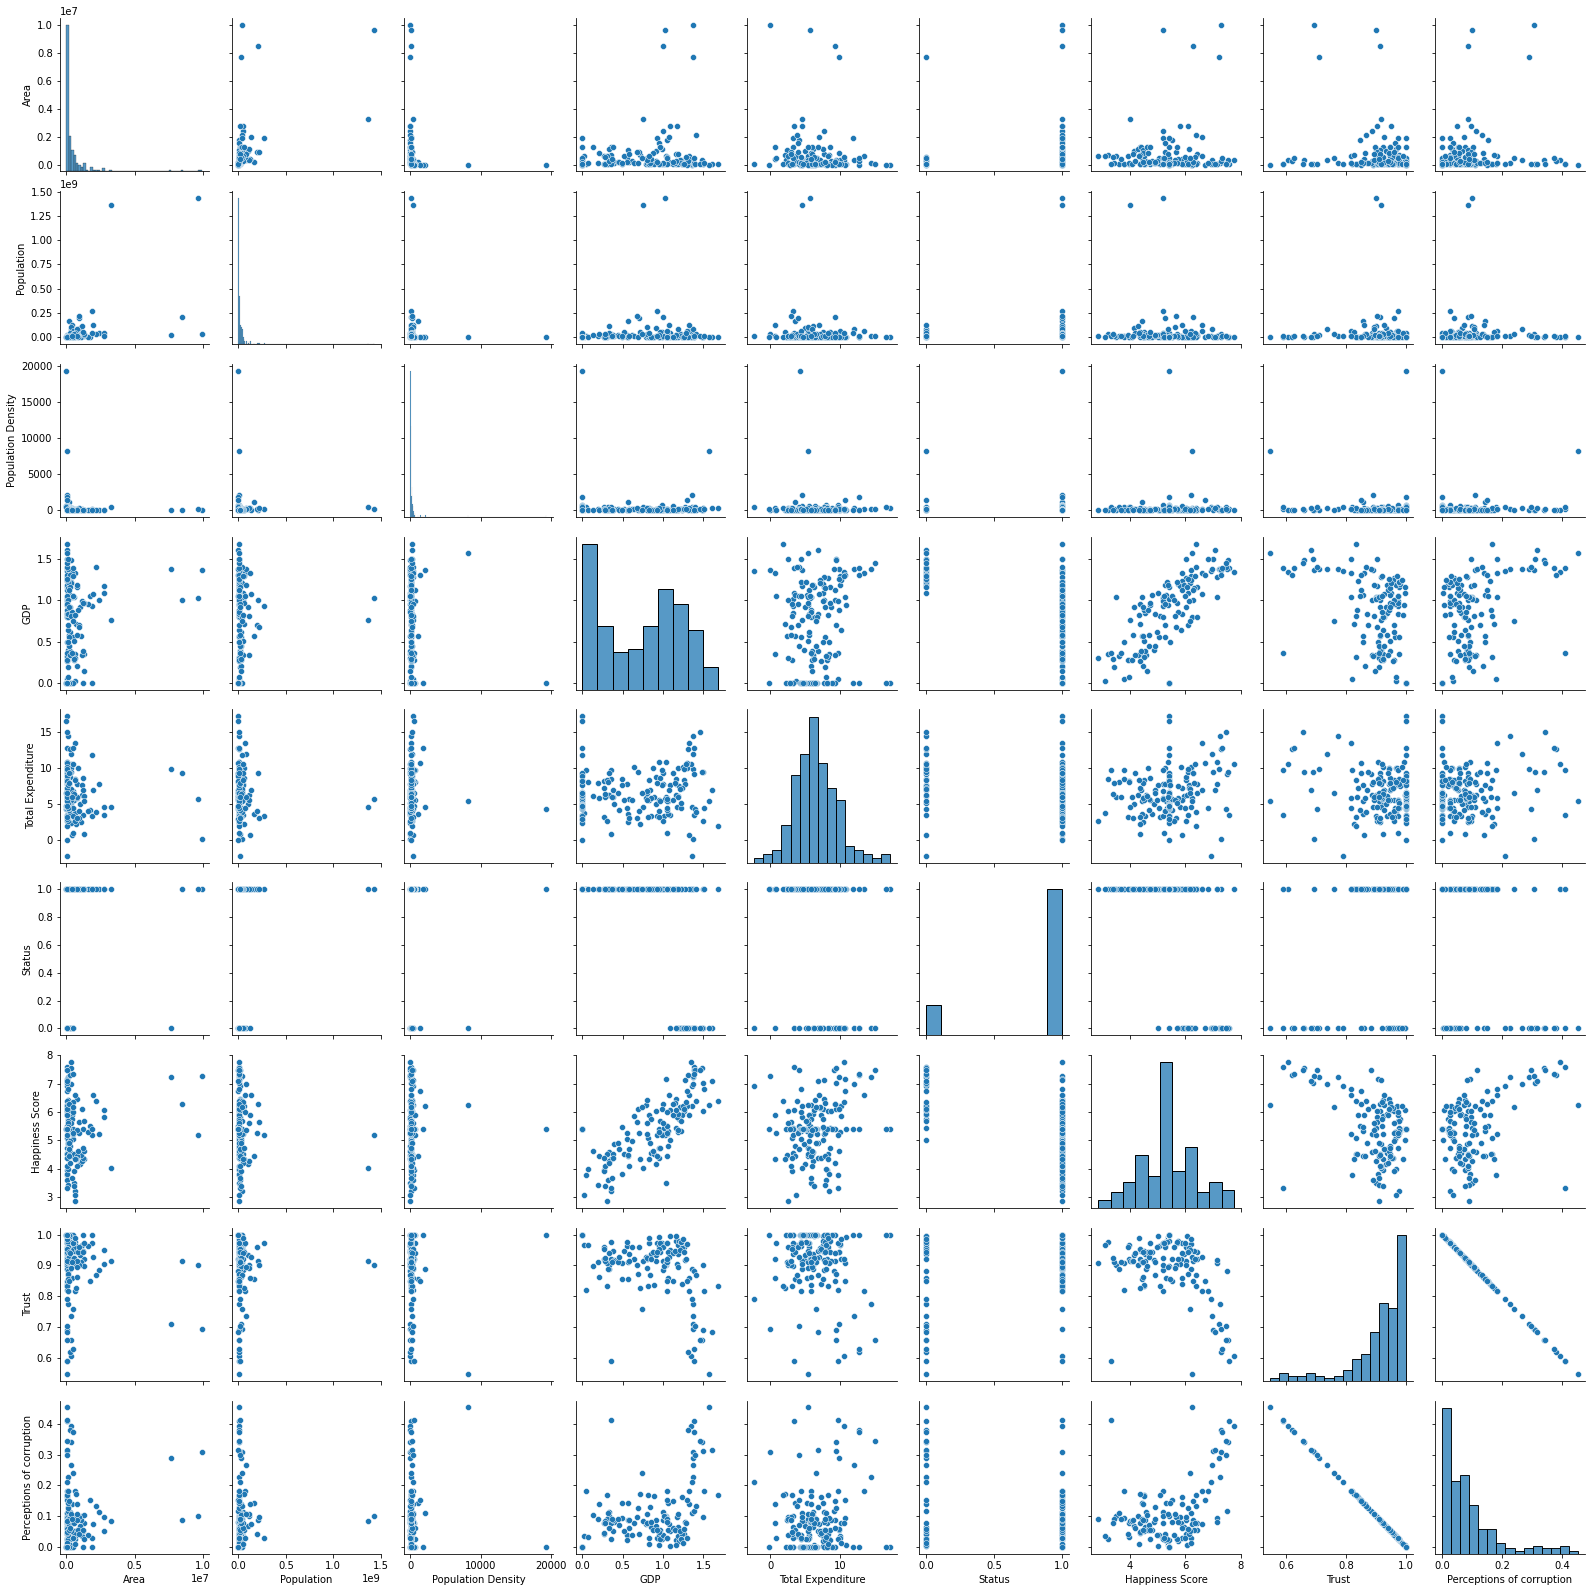

In [ ]:
sns.pairplot(Final_Dataset) 

#### **The 1st step: Detect Outliers**

* Here we used box plots on the attributes that concern us the most (Population Density,  GDP,   Total Expenditure, Happiness Score, Trust, Perceptions of corruption)and excluded the Country, Area, Population, and Status. 

* Since the Area and Population columns were already used to engineer our Population Density feature, our concern divert more towards the new feature engineered.


* The Status column was not included as well since it was already encoded, therefore, it's not possible to find any outliers.  

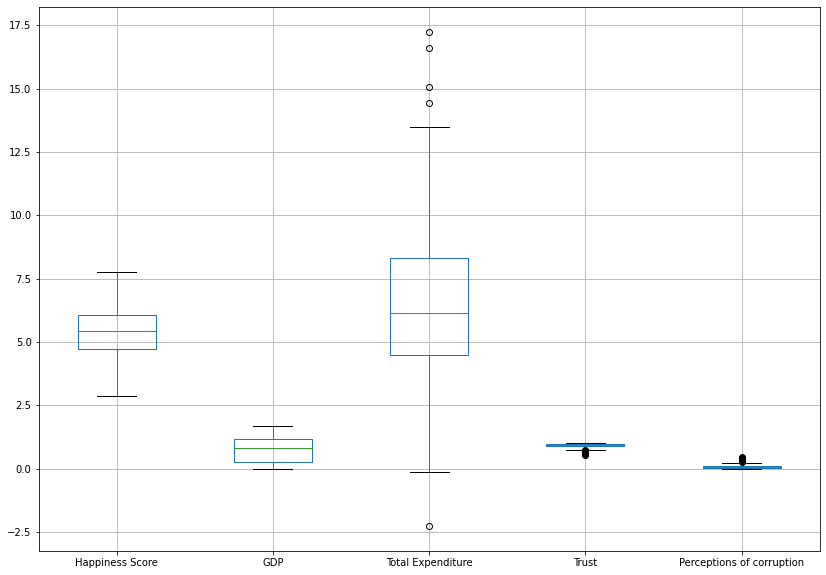

In [ ]:
fig1 = Final_Dataset.boxplot(column=['Happiness Score','GDP','Total Expenditure','Trust', 'Perceptions of corruption'], figsize=(14,10))

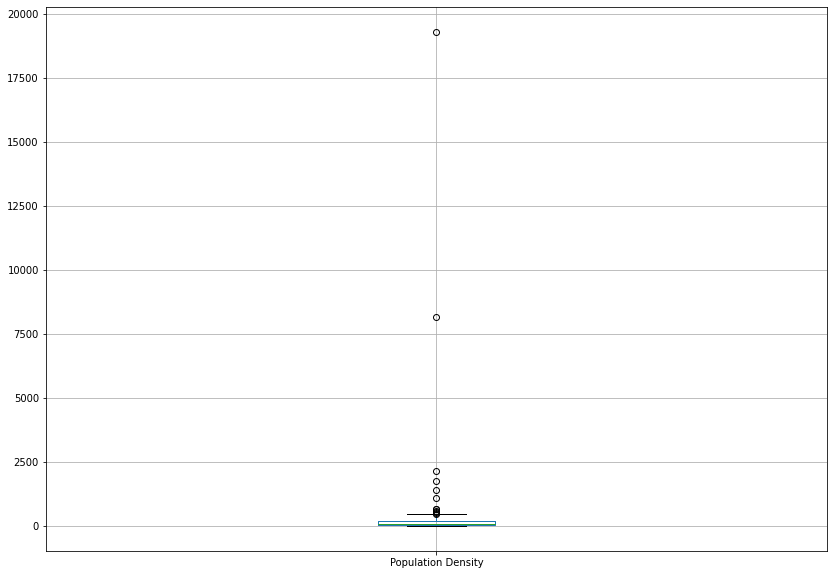

In [ ]:
fig2 = Final_Dataset.boxplot(column=['Population Density'], figsize=(14,10))

**From the box plots above, we can see that :**


* The Population Density has the most outliers that must be removed or at least minimized. 

* The Total Expenditure has the 2nd highest outliers.

* Trust and Perceptions of corruption has the least number of outliers, while GDP and Happiness Score has no outliers at all. 

From these observations, we decided to focus on the Population Density as our first priority.

#### **The 2nd step: Remove Outliers**
We applied LOF (the local outlier factor) to the four attributes (Population Density, Total Expenditure, Trust, and Perceptions of corruption) to minimize the effect of outliers 



In [ ]:
def LOF(df, column):
  X = df[[column]].values
  lof = LocalOutlierFactor()
  yhat = lof.fit_predict(X)
  mask = yhat != -1
  X_filtered = X[mask, :]
  return X_filtered

populationDensity = LOF(Final_Dataset,"Population Density")
totalExpenditure = LOF(Final_Dataset,"Total Expenditure")
perceptionCorruption = LOF(Final_Dataset,"Perceptions of corruption")
trust = LOF(Final_Dataset,"Trust")

FinalDB_withoutOutliers= Final_Dataset.copy()

FinalDB_withoutOutliers['Population Density'].replace(populationDensity)
FinalDB_withoutOutliers['Total Expenditure'].replace(totalExpenditure)
FinalDB_withoutOutliers['Trust'].replace(trust)
FinalDB_withoutOutliers['Perceptions of corruption'].replace(perceptionCorruption)

FinalDB_withoutOutliers.to_csv (r'FinalDB_withoutOutliers.csv', index = False, header=True,encoding='utf-8-sig')
FinalDB_withoutOutliers.head()

,Country,Area,Population,Population Density,GDP,Total Expenditure,Status,Happiness Score,Trust,Perceptions of corruption
0,afghanistan,652230.0,38041754,58.325673,0.350,8.410456,1,3.203000,0.975,0.025
41,albania,28748.0,2880917,100.212780,0.947,5.478015,1,4.719000,0.973,0.027
1,algeria,2381741.0,43053054,18.076295,1.002,7.790429,1,5.211000,0.886,0.114
2,angola,1246700.0,31825295,25.527629,0.000,3.363476,1,5.418439,1.000,0.000
42,antigua and barbuda,442.0,97118,219.723982,0.000,6.071048,1,5.418439,1.000,0.000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'Total Expenditure Distribution')

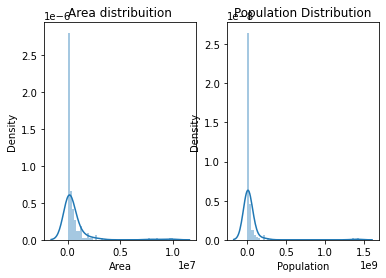

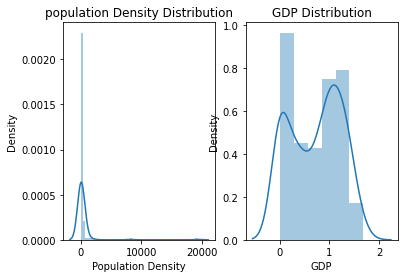

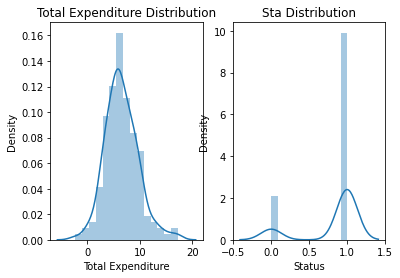

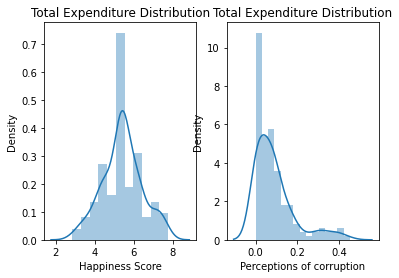

In [ ]:
Final = FinalDB_withoutOutliers.copy()

fig, ax=plt.subplots(1,2)
sns.distplot(Final["Area"], ax=ax[0])
ax[0].set_title("Area distribuition")

sns.distplot(Final["Population"], ax=ax[1])
ax[1].set_title("Population Distribution")

fig, ax=plt.subplots(1,2)
sns.distplot(Final["Population Density"], ax=ax[0])
ax[0].set_title("population Density Distribution")

sns.distplot(Final["GDP"], ax=ax[1])
ax[1].set_title("GDP Distribution")

fig, ax=plt.subplots(1,2)
sns.distplot(Final["Total Expenditure"], ax=ax[0])
ax[0].set_title("Total Expenditure Distribution")

sns.distplot(Final["Status"], ax=ax[1])
ax[1].set_title("Sta Distribution")

fig, ax=plt.subplots(1,2)
sns.distplot(Final["Happiness Score"], ax=ax[0])
ax[0].set_title("Total Expenditure Distribution")

sns.distplot(Final["Perceptions of corruption"], ax=ax[1])
ax[1].set_title("Total Expenditure Distribution")




#### **The 3rd Step: Apply Normalization**
We first need to check the ditribution of the data to choose one of the normalization techniques.

In [ ]:

def Zscore_Scaling(df, column):
  a_original = df[column]
  a_scaled = StandardScaler().fit_transform(df[[column]]) 
  return a_original ,a_scaled

def MinMax_Scaling(df, column):
  a_original = df[column]
  a_scaled = MinMaxScaler().fit_transform(df[[column]]) 
  return a_original ,a_scaled

def BoxCoxNormalize(df, column):
  a_original = df[column] > 0
  positives = df[column].loc[a_original.index]
  normalized = stats.boxcox(positives)[0]
  return positives, normalized

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'Status distribution')

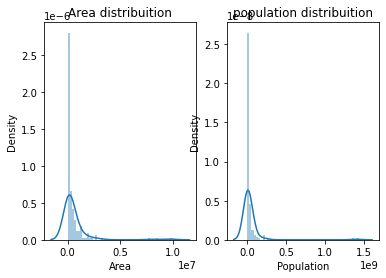

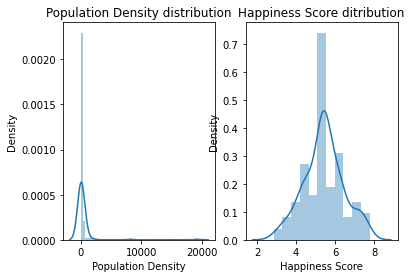

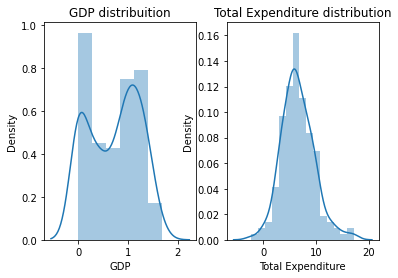

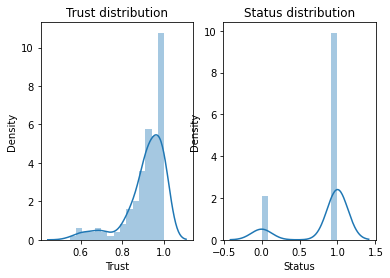

In [ ]:
Final = FinalDB_withoutOutliers.copy()
#------------------View Distributions----------------------#
fig, ax=plt.subplots(1,2)
sns.distplot(Final["Area"], ax=ax[0])
ax[0].set_title("Area distribuition")
sns.distplot(Final["Population"], ax=ax[1])
ax[1].set_title("population distribuition")

fig, ax=plt.subplots(1,2)
sns.distplot(Final["Population Density"], ax=ax[0])
ax[0].set_title("Population Density distribution")
sns.distplot(Final["Happiness Score"], ax=ax[1])
ax[1].set_title("Happiness Score ditribution")


fig, ax=plt.subplots(1,2)
sns.distplot(Final["GDP"], ax=ax[0])
ax[0].set_title("GDP distribuition")
sns.distplot(Final["Total Expenditure"], ax=ax[1])
ax[1].set_title("Total Expenditure distribution")


fig, ax=plt.subplots(1,2)
sns.distplot(Final["Trust"], ax=ax[0])
ax[0].set_title("Trust distribution")
sns.distplot(Final["Status"], ax=ax[1])
ax[1].set_title("Status distribution")

The above distribution shows that the following techniques should be used:

1. MinMax Scalar Normalization: This technique will be done on the happiness score and total expanditure because they are normally distributed.

2. Box Cox Normalization: This technique will be done on the Population Desnity, Area, and trust because they are skewed.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

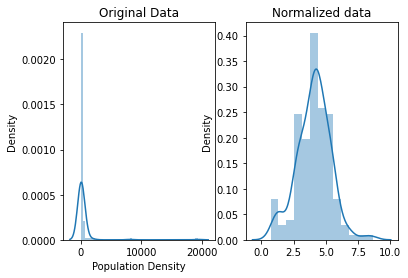

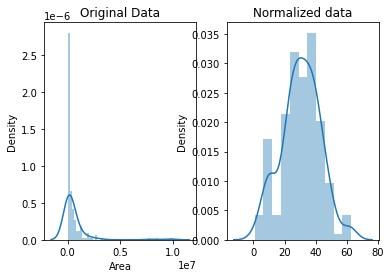

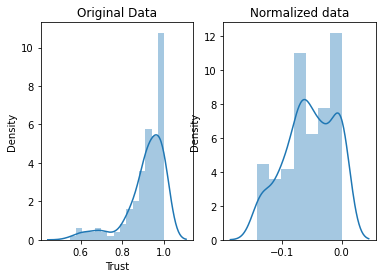

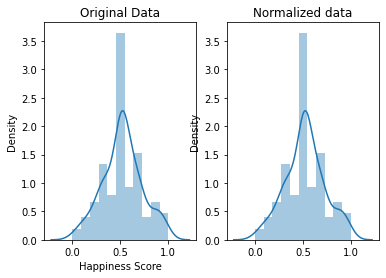

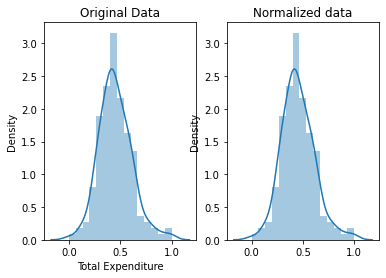

In [ ]:
#-----------------Normalize the Data---------------------#
positives, normalized = BoxCoxNormalize(Final, 'Population Density')
Final['Population Density'] = normalized

fig, ax=plt.subplots(1,2)
sns.distplot(positives, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized, ax=ax[1])
ax[1].set_title("Normalized data")

positives, normalized = BoxCoxNormalize(Final, 'Area')
Final['Area'] = normalized

fig, ax=plt.subplots(1,2)
sns.distplot(positives, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized, ax=ax[1])
ax[1].set_title("Normalized data")



positives, normalized = BoxCoxNormalize(Final, 'Trust')
Final['Trust'] = normalized

fig, ax=plt.subplots(1,2)
sns.distplot(positives, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized, ax=ax[1])
ax[1].set_title("Normalized data")


positives, normalized = MinMax_Scaling(Final, 'Happiness Score')
Final['Happiness Score'] = normalized

fig, ax=plt.subplots(1,2)
sns.distplot(positives, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized, ax=ax[1])
ax[1].set_title("Normalized data")


positives, normalized = MinMax_Scaling(Final, 'Total Expenditure')
Final['Total Expenditure'] = normalized

fig, ax=plt.subplots(1,2)
sns.distplot(positives, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized, ax=ax[1])
ax[1].set_title("Normalized data")





Final.to_csv (r'Final.csv', index = False, header=True,encoding='utf-8-sig')


#### **The 4th step: Visualize** 

The visualizations will enable us to answer our research questions and infer if the Country's Nature does affect the happiness score of a country or not.

Now let's break down how we defined a country's nature and see how each factor impact the Happiness level. 

##### **Part A: Visualize the Data** 

We will visualize the features of the countries in the below world map with each country haviing all features present by clicking on the country.

In [ ]:
pip install folium

In [ ]:
#--------------- Read DataSet with longitude and latitude of countries------------
file_id = '1jY3Hp8164CkXX97bPsDaY8M-3bqTRqEs'
download_file_from_google_drive(file_id, './locate.csv')

In [ ]:
#--------------------------merge to get updated map--------------------------------------------------#
geocoding_data = pd.read_csv('/content/locate.csv',encoding= 'unicode_escape')
country = geocoding_data['name'].str.lower()
geocoding_data["name"] = country
geocoding_data=geocoding_data.drop(["country"],axis =1 )
geocoding_data.rename(columns = {'name':'Country'}, inplace = True) 
Final_world_map = pd.merge(Final, geocoding_data, how='inner', on=["Country"])
Final_world_map.to_csv (r'Final_world_map.csv', index = False, header=True,encoding='utf-8-sig')

In [ ]:
print(geocoding_data)

      latitude  longitude               Country
0    42.546245   1.601554               andorra
1    23.424076  53.847818  united arab emirates
2    33.939110  67.709953           afghanistan
3    17.060816 -61.796428   antigua and barbuda
4    18.220554 -63.068615              anguilla
..         ...        ...                   ...
240  15.552727  48.516388                 yemen
241 -12.827500  45.166244               mayotte
242 -30.559482  22.937506          south africa
243 -13.133897  27.849332                zambia
244 -19.015438  29.154857              zimbabwe

[245 rows x 3 columns]


In [ ]:
#-------------------- World Map--------------------------#
import folium
from folium.plugins import MarkerCluster
#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
df = pd.read_csv('/content/Final_world_map.csv')
#for each coordinate, create circlemarker of user percent
for i in range(len(df)):
        lat = df.iloc[i]['latitude']
        longt = df.iloc[i]['longitude']
        radius=5
        popup_text = """Country : {}<br>
                        population Density : {}<br>
                        GDP : {}<br>
                        Happiness Score : {}<br>
                     
                    """
        popup_text = popup_text.format(
                                     df.iloc[i]['Country'],
                                     df.iloc[i]['Population Density'],
                                     df.iloc[i]['GDP'],  
                                   df.iloc[i]['Happiness Score'])
        folium.CircleMarker(location = [lat, longt], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map



#####**Part B: First we have the Development Status of the country.**

* We can observe from the visualization below that already developed countries tend to have a higher happiness score than countries that are still in the developing phase. 

* Therefore, we can conclude that the status of a country have an impact on the score of happiness of its people.

* Which means that a country's development status and it's happiness score has a **strong positive correlation**

[Text(0, 0.5, 'Happiness Score'),
 Text(0.5, 0, 'Status (0= developed and 1= developing)')]

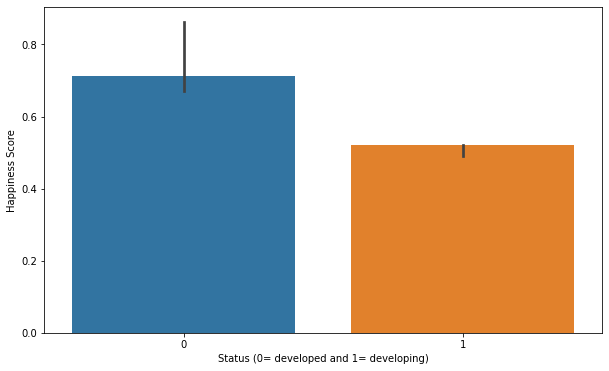

In [ ]:
plt.figure(figsize=(10,6))
bp_tips = sns.barplot(x='Status', y='Happiness Score', data=Final_world_map, estimator=np.median)
bp_tips.set(xlabel="Status (0= developed and 1= developing)",ylabel="Happiness Score")

##### **The Second Factor we have is the GDP(Gross Domestic Product) per Capita of a country**

* Here there's an obvious **strong positive correlation** between the happiness score and the GDP of a country. 

* Since GDP is a metric that breaks down a country's economic output per person, it means that the economy of a country has direct linear relation with the happiness score in this country.

* As the GDP increases, the Happiness score increases.


<Figure size 720x432 with 0 Axes>

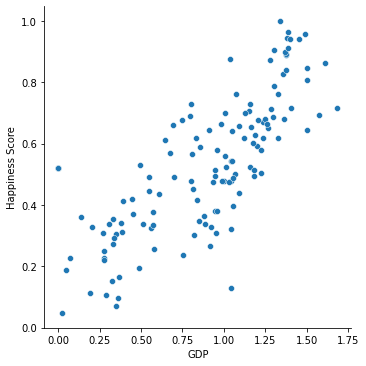

In [ ]:
plt.figure(figsize=(10,6))
sns.relplot(
    data=Final_world_map, x="GDP", y="Happiness Score", 
)

##### **The Third is Population Density** 

* We started with a line plot, since the Population Density variable is continuous.

* But the correlation is really vague, so we decided to use a joint plot.

* From the joint plot below, we can observe that the relation between population density and the happiness score has somewhat a **weak to almost no correlation**.

* As the values seem scattered on the plot, some values tend to concentrate in the middle of the plot where the population density ranges between 2 to 6.

* Although it would be a very weak observation, we can say that moderate population density tend to have moderate happiness score. 




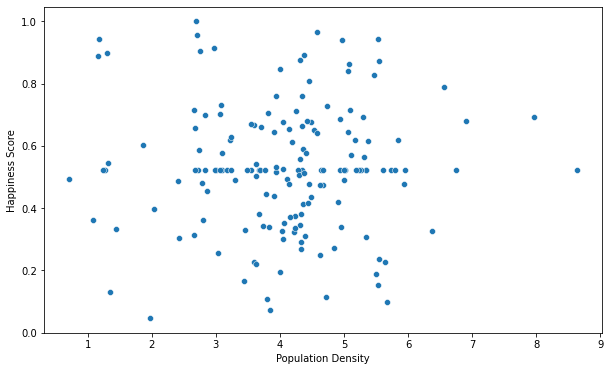

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=Final_world_map,
             x="Population Density", y="Happiness Score", ci="sd")

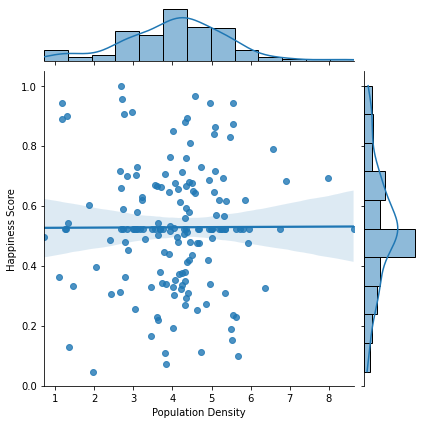

In [ ]:
sns.jointplot(x='Population Density',y='Happiness Score',data=Final_world_map, kind= 'reg')

##### **The Fourth is Total Expenditure**

* Here from the first plot, we can infer almost no relation between Total Expenditure and Happiness score.

* So as a work around to be able to visualize the correlation more clearly, we used **Discretization** on the Happiness Score attribute and assigned a label to each of the 6 levels (very low, low, slightly low, medium, slightly high, high, very high).

* We then used a bar plot to visualize the Happiness Levels with the Total Expenditure.

* We were able to observe that the more the country spend on the Health in general the better the happiness levels are.

* Which we can consider it as a positive correlation.


In [ ]:
CutDB1 = Final_world_map.copy()
popDen2 = pd.cut(CutDB1['Happiness Score'], [0,.15,.30,.45,.60,.75,.90,1.05], labels=['very low','low','slightly low','medium', 'slightly high','high', 'very high'])
CutDB1['Happiness Score'] = popDen2

display(CutDB1.head())

,Country,Area,Population,Population Density,GDP,Total Expenditure,Status,Happiness Score,Trust,Perceptions of corruption,latitude,longitude
0,afghanistan,40.310737,38041754,3.844960,0.350,0.547226,1,very low,-0.023219,0.025,33.939110,67.709953
1,albania,23.306623,2880917,4.324827,0.947,0.396852,1,slightly low,-0.024929,0.027,41.153332,20.168331
2,algeria,49.911517,43053054,2.781356,1.002,0.515431,1,medium,-0.081890,0.114,28.033886,1.659626
3,angola,44.891552,31825295,3.098345,0.000,0.288420,1,medium,0.000000,0.000,-11.202692,17.873887
4,antigua and barbuda,9.703458,97118,5.008174,0.000,0.427263,1,medium,0.000000,0.000,17.060816,-61.796428


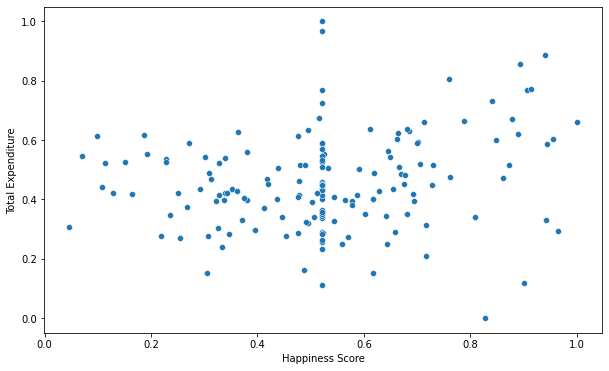

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Happiness Score', y='Total Expenditure', data=Final_world_map)

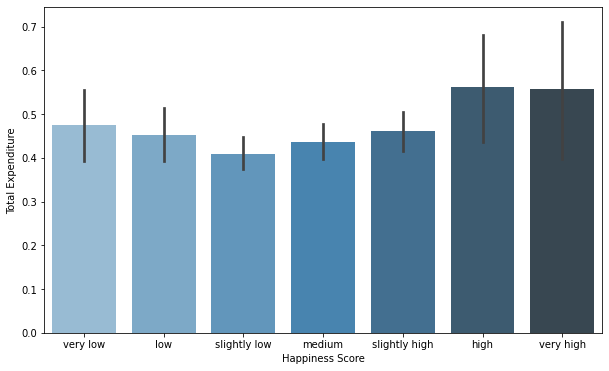

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='Happiness Score', y=Final_world_map['Total Expenditure'], data=CutDB1, palette="Blues_d")

##### **The Fifth is the Trust attribute**



* The observation drawn from the output plot was that the higher the trust between a government and its people, the more happiness score is actually recorded.

* Just to make sure of our observation, we used a reg plot to plot the continuous Trust variable divided into bins.

* A **weak negative correlation** is observed with the reg plot, which give us a new piece of information.
 
 As long as there's trust between the government and it's people, the people are not afraid to say that they may not be happy. 
 
 Except for few cases can be observed on the plot, where the trust is very low and the happiness score is very high. This may indicate fear of the government resulting from lack of trust. 

* Therefore, we can conclude that the higher the trust between people and their government, the better the focus on happiness and the better people can express themselves.


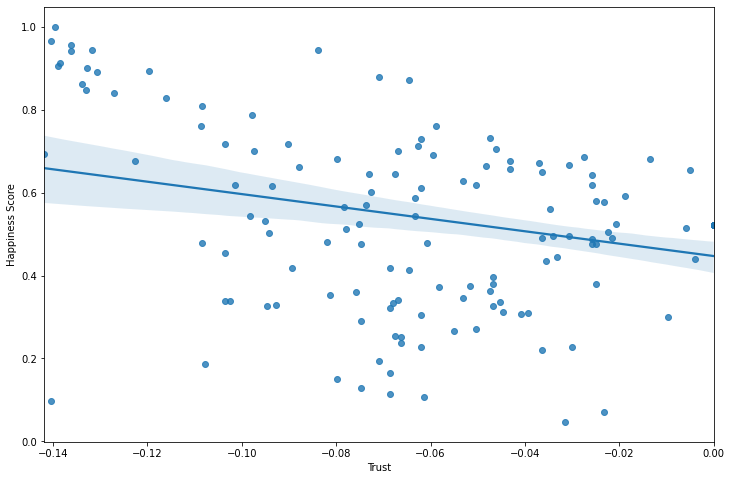

In [ ]:
plt.figure(figsize=(12,8))
sns.regplot(data=Final_world_map,
             x ="Trust",y ="Happiness Score")

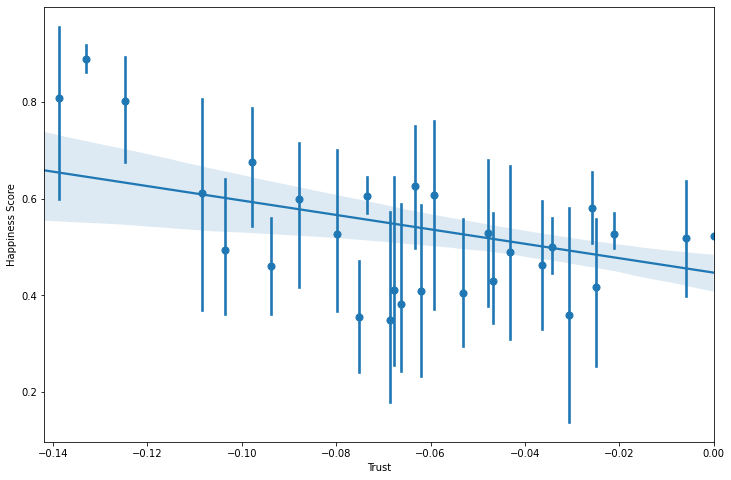

In [ ]:
plt.figure(figsize=(12,8))
sns.regplot(data=Final_world_map,
             x ="Trust",y ="Happiness Score", x_bins=35)

##### **The Sixth attribute is the Perceptions of corruption**

* From the plot below, we can say that the relation between the Happiness Score and the Perception of corruption of a country is a **positive correlation**. 

* We can infer from this correlation that if a country's government is corrupt, the less the people enjoy their time.

* Also the correlation shows that the less the corruption in a country, the more the happiness score is actually recorded.



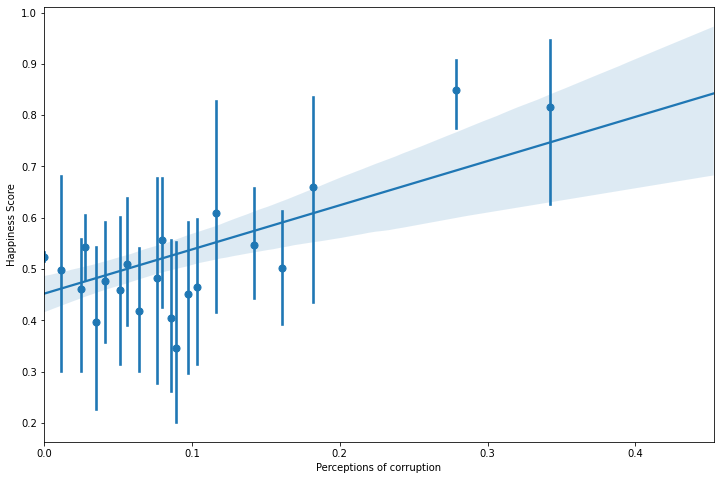

In [ ]:
plt.figure(figsize=(12,8))
sns.regplot(data=Final_world_map,
             x ="Perceptions of corruption",y ="Happiness Score", x_bins=25)

Conclusion:


---
This section includes the foundings of the project.

Based on the above figures we can conclude that there is a strong relation between the country's nature and the happiness of its citizens. We have defined the nature of the country to be its population density, status, total health expanditure, and trust. Moreover we have found that some of them have a strong effect on the happiness score while others have weak or no effect on it.

By investigating the visualizations we have found the following:
1. The higher the GDP the happier the citizens were since the relation between the GDP and happiness score was positive.
2. The population density has no effect on the happiness score.
3. Developed countries tend to be happier than those of countries that are still developing.
4. We were able to observe that the more the country spend on the Health in general the better the happiness levels are.
5. we can conclude that the higher the trust between people and their government, the better the focus on happiness and the better people can express themselves; accordingly, we can infer from this correlation that if a country's government is corrupt, the less the people enjoy their time.

Finally, the project supports that most of people’s happiness is driven by a strong economic growth, healthy life expectancy, trust, and a country that has developed and is stable.